In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import string
import os
import cv2
from glob import glob

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import torchvision.transforms as transforms

from barbar import Bar

In [2]:
train_data_raw = np.array(glob('asl-alphabet/asl_alphabet_train/asl_alphabet_train/*/*'))
test_data_raw = np.array(glob('asl-alphabet/asl_alphabet_test/asl_alphabet_test/*'))

In [3]:
print('There are %d total train images.' % len(train_data_raw))
print('There are %d total test images.' % len(test_data_raw)) #No test image for delete

There are 87000 total train images.
There are 28 total test images.


In [4]:
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler

In [7]:
# percentage of training set to use as validation
valid_size = 0.2

train_transform = transforms.Compose([ transforms.Grayscale(num_output_channels=1),
                                transforms.Resize(size=(50,50)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5])])
valid_transform = transforms.Compose([ transforms.Grayscale(num_output_channels=1),
                                    transforms.Resize(50),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.5], [0.5])])
test_transform = transforms.Compose([ transforms.Grayscale(num_output_channels=1),
                                    transforms.Resize(size=(50,50)),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.5], [0.5])])

train_data = datasets.ImageFolder(root = 'asl-alphabet/asl_alphabet_train/asl_alphabet_train', transform=train_transform)
test_data = datasets.ImageFolder(root='asl-alphabet/asl_alphabet_test', transform=test_transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# print number of images in each dataset
print('There are %d total train images.' % len(indices[split:]))
print('There are %d total validation images.' % len(indices[:split]))
print('There are %d total test images.' % len(test_data))


trainloader = torch.utils.data.DataLoader(train_data, batch_size=20,sampler=train_sampler)
validloader = torch.utils.data.DataLoader(train_data, batch_size=20,sampler=valid_sampler)
testloader = torch.utils.data.DataLoader(test_data,batch_size=20, shuffle=False)


loaders = dict(train=trainloader,
                       valid = validloader,
                       test=testloader)

There are 69600 total train images.
There are 17400 total validation images.
There are 28 total test images.


In [8]:
dim=50

In [9]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1,10,3)
        self.conv2 = nn.Conv2d(10,20,3)
        self.conv3 = nn.Conv2d(20,30,3)
        
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout2d(0.2)
        
        self.fc1 = nn.Linear(2430, 270)
        self.fc2 = nn.Linear(270,29)
        
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self,x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.softmax(F.relu(self.fc2(x)))
        return(x)
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [10]:
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    model = Network().cuda()
else:
    model = Network()

In [11]:
summary(model, (1,dim,dim)) #takes the model and the input tensor shape, displays the output shape

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 48, 48]             100
         MaxPool2d-2           [-1, 10, 24, 24]               0
            Conv2d-3           [-1, 20, 22, 22]           1,820
         MaxPool2d-4           [-1, 20, 11, 11]               0
            Conv2d-5             [-1, 30, 9, 9]           5,430
         Dropout2d-6             [-1, 30, 9, 9]               0
            Linear-7                  [-1, 270]         656,370
            Linear-8                   [-1, 29]           7,859
        LogSoftmax-9                   [-1, 29]               0
Total params: 671,579
Trainable params: 671,579
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.35
Params size (MB): 2.56
Estimated Total Size (MB): 2.92
-------------------------------------------

In [12]:
epochs = 50
learning_rate = 0.001

In [13]:
optimizer = optim.SGD(model.parameters(), learning_rate, momentum=0.007)
criterion = nn.CrossEntropyLoss()

In [14]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        print('Epoch: {} '.format(
        epoch
        ))
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(Bar(loaders['train'])):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output,target)
            loss.backward()
            optimizer.step()
            
            train_loss = train_loss + ((1/(batch_idx +1))*(loss.data - train_loss))
            
#             if batch_idx % 1000 == 0:
#                 print('Epoch %d, Batch %d loss: %.6f' %(epoch, batch_idx + 1, train_loss))
            
#         print('Training Loss: {:.6f} '.format(
#         train_loss
#         ))
                
    # return trained model
#     return model
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output,target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))


#       print training/validation statistics 
        print('  Training Loss: {:.6f} \tValidation Loss: {:.6f}'.format( 
            train_loss,
            valid_loss
            ))
        
        ## save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [13]:
# train the model
# model_scratch = train(epochs, loaders, model, optimizer, criterion, use_cuda, 'saved_model.pt')

Epoch: 1 
69600/87000: [===============================>] - ETA 0.3ssss  Training Loss: 3.366137 	Validation Loss: 3.364683
Validation loss decreased (inf --> 3.364683).  Saving model ...
Epoch: 2 
69600/87000: [===============================>] - ETA 0.0sss  Training Loss: 3.363264 	Validation Loss: 3.360312
Validation loss decreased (3.364683 --> 3.360312).  Saving model ...
Epoch: 3 
69600/87000: [===============================>] - ETA 0.0sss  Training Loss: 3.356340 	Validation Loss: 3.347574
Validation loss decreased (3.360312 --> 3.347574).  Saving model ...
Epoch: 4 
69600/87000: [===============================>] - ETA 0.1sss  Training Loss: 3.332255 	Validation Loss: 3.297224
Validation loss decreased (3.347574 --> 3.297224).  Saving model ...
Epoch: 5 
69600/87000: [===============================>] - ETA 0.0sss  Training Loss: 3.262462 	Validation Loss: 3.185503
Validation loss decreased (3.297224 --> 3.185503).  Saving model ...
Epoch: 6 
69600/87000: [====================

In [16]:
# load the model that got the best validation accuracy 
if use_cuda:
    infer_model = Network().cuda()
else:
    infer_model = Network()
infer_model.load_state_dict(torch.load('saved_model.pt'))

<All keys matched successfully>

In [72]:
dict_labels = {
    0:'A',
    1:'B',
    2:'C',
    3:'D',
    4:'E',
    5:'F',
    6:'G',
    7:'H',
    8:'I',
    9:'J',
    10:'K',
    11:'L',
    12:'M',
    13:'N',
    14:'O',
    15:'P',
    16:'Q',
    17:'R',
    18:'S',
    19:'T',
    20:'U',
    21:'V',
    22:'W',
    23:'X',
    24:'Y',
    25:'Z',
    26:'del',
    27:'nothing',
    28:'space'
    
}

0


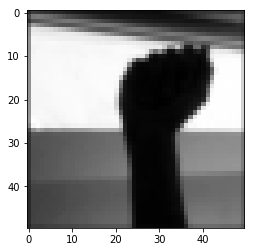

Prediction: A
correct 0.0
1


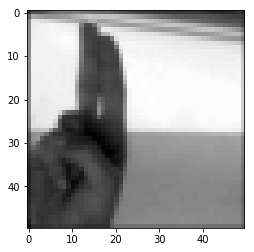

Prediction: U
correct 20.0

Test Loss: 28.085033


Test Accuracy: 71% (20/28)


In [57]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
    
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        
        _, preds_tensor = torch.max(output, 1)

        predimg = np.squeeze(preds_tensor.numpy()[0]) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy()[0])
        print(batch_idx)
        np_img = data.cpu().numpy()[0][0]
        plt.imshow(np_img, cmap='gray')
        plt.show()
        
        print("Prediction: {}".format(dict_labels[predimg]))
        
        # compare predictions to true label
        correct += np.sum(predimg)
        print("correct",correct)
#         correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
    
            
    print('\nTest Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * float(correct / total), correct, total))

# call test function    
test(loaders, infer_model, criterion, use_cuda)

In [73]:
# def imshow(inp, title=None): 
#     """Imshow for Tensor."""
#     inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
#     inp = np.clip(inp, 0, 1)
#     plt.imshow(inp)
#     if title is not None:
#         plt.title(title)
#     plt.pause(0.001)  # pause a bit so that plots are updated


# # Get a batch of training data
# inputs, classes = next(iter(loaders['test']))

# # Make a grid from batch
# out = torchvision.utils.make_grid(inputs)

# imshow(out, title=[dict_labels[x] for x in classes])

KeyError: tensor(0)

In [18]:
for batch_idx, (data, target) in enumerate(loaders['test']):
    print(data,target)

tensor([[[[-0.5686, -0.4431, -0.4745,  ..., -0.4667, -0.4431, -0.4745],
          [-0.3490, -0.0196, -0.0039,  ..., -0.1922, -0.1843, -0.2863],
          [-0.4980, -0.2941, -0.2706,  ..., -0.3412, -0.2784, -0.3412],
          ...,
          [-0.5686, -0.4118, -0.3882,  ...,  0.0118,  0.0118, -0.1216],
          [-0.5608, -0.3961, -0.3804,  ...,  0.0275,  0.0275, -0.1216],
          [-0.6000, -0.4588, -0.4510,  ..., -0.1059, -0.1137, -0.2235]]],


        [[[-0.7020, -0.6549, -0.6549,  ..., -0.0824, -0.0588, -0.1922],
          [-0.6471, -0.5529, -0.5608,  ...,  0.4353,  0.4510,  0.2314],
          [-0.5686, -0.4431, -0.4588,  ...,  0.3176,  0.3490,  0.1686],
          ...,
          [-0.2706,  0.1137,  0.1216,  ...,  0.1451,  0.1294, -0.0353],
          [-0.2627,  0.1216,  0.1216,  ...,  0.1373,  0.1216, -0.0510],
          [-0.3569, -0.0431, -0.0353,  ..., -0.0275, -0.0510, -0.1922]]],


        [[[-0.6941, -0.6314, -0.6314,  ..., -0.0510, -0.0275, -0.1686],
          [-0.6157, -0.505

In [106]:
def predict(img_path):
    # load the image and return the predicted breed
    img = Image.open(img_path)
#     img = Image.open(img_path).convert('L')
    transformations = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                            transforms.Resize(size=50),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.5],[0.5])])
    image_tensor = transformations(img)[:3,:,:].unsqueeze(0)
#     image_tensor = transformations(img)[:3,:,:].unsqueeze(0)

    # move model inputs to cuda, if GPU available
    if use_cuda:
        image_tensor = image_tensor.cuda()

    # get sample outputs
    output = infer_model(image_tensor)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)

    pred = np.squeeze(preds_tensor.numpy()[0]) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy()[0])

    return dict_labels[pred]

In [107]:
# plt.figure(figsize=(10,8))
# plt.plot(loss_log[2:])
# plt.plot(acc_log)
# plt.plot(np.ones(len(acc_log)), linestyle='dashed')
# plt.show()

In [108]:
prediction = predict('Inference_Images/c.jpg')
lab = 'c'

In [109]:
print("Prediction: {}".format(prediction))
print("Actual Label: {}".format(lab))

Prediction: nothing
Actual Label: c


In [19]:
# pixels = cv2.imread('./c.jpg').reshape(28, 28)
# plt.subplot(223)
# sns.heatmap(data=pixels)
# lab = 'c'
# test_sample = torch.FloatTensor([pixels.reshape(1, 28, 28).tolist()])
# pred = model(Variable(input_img))
# print("Prediction: {}".format(alph[torch.max(net_out_sample.data, 1)[1].numpy()[0]]))
# print("Actual Label: {}".format(lab))


In [20]:
def predictor(img):
    # load the image and return the predicted breed
#     img = Image.open(img_path).convert('L')
    img = Image.fromarray(img)
    transformations = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                            transforms.Resize(size=50),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.5],[0.5])])
    image_tensor = transformations(img)[:3,:,:].unsqueeze(0)

    # move model inputs to cuda, if GPU available
    if use_cuda:
        image_tensor = image_tensor.cuda()

    # get sample outputs
    output = infer_model(image_tensor)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)

    pred = np.squeeze(preds_tensor.numpy()[0]) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy()[0])

    return dict_labels[pred]

In [21]:
vc = cv2.VideoCapture(0)
rval, frame = vc.read()
old_text = ''
pred_text = ''
count_frames = 0
total_str = ''
flag = False

while True:
    
    if frame is not None: 
        
        frame = cv2.flip(frame, 1)
        frame = cv2.resize( frame, (400,400) )
        
        cv2.rectangle(frame, (300,300), (100,100), (0,255,0), 2)
        
        crop_img = frame[100:300, 100:300]
        grey = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
        
        thresh = cv2.threshold(grey,210,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]
      
        
        blackboard = np.zeros(frame.shape, dtype=np.uint8)
        cv2.putText(blackboard, "Predicted text - ", (30, 40), cv2.FONT_HERSHEY_TRIPLEX, 1, (255, 255, 0))
        if count_frames > 20 and pred_text != "":
            total_str += pred_text
            count_frames = 0
            
        if flag == True:
            old_text = pred_text
            pred_text = predictor(thresh)
        
            if old_text == pred_text:
                count_frames += 1
            else:
                count_frames = 0
            cv2.putText(blackboard, total_str, (30, 80), cv2.FONT_HERSHEY_TRIPLEX, 1, (255, 255, 127))
        res = np.hstack((frame, blackboard))
        
        cv2.imshow("image", res)
        cv2.imshow("hand", thresh)
        
    rval, frame = vc.read()
    keypress = cv2.waitKey(1)
    if keypress == ord('c'):
        flag = True
    if keypress == ord('q'):
        break

vc.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

vc.release()